In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline


In [37]:
lineage_order = ["driver::send", 
                     "clipper::frontend_rpc_recv", 
                     "clipper::task_enqueued", 
                     "clipper::task_dequeued", 
                     "clipper::sent_rpc", 
                     "container::recv",
                     "container::send", 
                     "clipper::rpc_recv", 
                     "clipper::task_executor_recv",
                     "clipper::task_executor_recv_end",
                    "clipper::task_executor_msg_callback_found",
                     "clipper::zmq_frontend_response_callback", 
                     "clipper::frontend_rpc_response_send", 
                     "driver::recv"]

points_to_include = [
#     "driver::send",                  
    "clipper::frontend_rpc_recv", 
    "clipper::task_enqueued",
    "clipper::task_dequeued",
    "clipper::sent_rpc",
    "container::recv",
    "container::send",
    "clipper::rpc_recv",
    "clipper::task_executor_recv",
    "clipper::task_executor_msg_callback_found",
    "clipper::task_executor_recv_end",
    "clipper::zmq_frontend_response_callback",
    "clipper::frontend_rpc_response_send",
    "driver::recv"
]

# def extract_lineage(lineage):
#     first_key = "driver::send"
# #     first_key = "clipper::frontend_rpc_recv"
# #     first_key = "clipper::task_dequeued"
# #     first_key = "container::send"

#     keys = lineage[0].keys()
#     extracted = {k: [] for k in lineage[0].keys()}
#     for entry in lineage:
#         start_timestamp = entry[first_key]
#         for k, v in entry.items():
#             if k != first_key and v > start_timestamp:
#                 extracted[k].append(float(v - start_timestamp) / 1000.0)
#     return extracted

def extract_lineage_deltas(lineage):
    first_key = "driver::send"
#     first_key = "clipper::frontend_rpc_recv"
#     first_key = "clipper::task_dequeued"
#     first_key = "container::send"

    extracted = {k: [] for k in lineage_order}
    for entry in lineage:
        for i in range(1,len(lineage_order)):
            try:
                k = lineage_order[i]
            
                previous_timestamp = entry[lineage_order[i-1]]
            
                delta = entry[k] - previous_timestamp
                extracted[k].append(float(delta) / 1000.0)
            except KeyError as e:
                print("CCCCCCCCCCCCCCCCCCC")
    return extracted



def analyze_lineage(path):
    with open(path, "r") as f:
        try:
            results = json.load(f)
        except e:
            print(e)
    
    try:
        extracted_lineage = extract_lineage_deltas(results["steady_results"]["lineage"])
        for k in lineage_order:
            v = extracted_lineage[k]
            if len(v) > 0:
                if k in points_to_include:
                    fig, (ax_scatter, ax_hist) = plt.subplots(ncols=2, figsize=(20,6))
                    ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.4, label=k)
                    ax_scatter.legend(loc=0)
                    ax_scatter.set_ylabel("Time (ms)")
        #             ax_hist.hist(v, 50, label=k, normed=1, histtype='step', cumulative=False,)
                    ax_hist.hist(v, 100, label=k, normed=True, histtype='bar', cumulative=False, log=True)
                    xmax = ax_hist.get_xlim()[1]
                    ax_hist.set_xlim(right=max(10, xmax))
                    ax_hist.set_xlabel("Time (ms)")
                    ax_hist.set_ylabel("Query ID")
                    ax_hist.set_ylabel("Count (normalized)")
                    ax_hist.grid(b=True, which="both")
                    fig.suptitle(k, fontsize=20)
                    plt.show()
    except KeyError as e:
        print("DDDDDDDDDDDDDDDDDDDD")
                
def compare_lineages(path, batch_size_fixed):
    fs = list(os.listdir(path))
    fs_dict = {}
    for f in fs:
        if f[-4:] == "json":
            splits = f.split("-")
            batch = int(splits[9])
            input_size = int(splits[11])
            if batch == batch_size_fixed:
                fs_dict[(batch, input_size)] = f
    sorted_fs = OrderedDict((k, fs_dict[k]) for k in sorted(list(fs_dict.keys())))
    figs = {}
    for point in points_to_include:
        figs[point] = plt.subplots(ncols=2, figsize=(20,6))
    for (batch, input_size), f in sorted_fs.items():
        try:
            fpath = os.path.join(path, f)
            with open(fpath, "r") as f:
                results = json.load(f)
            extracted_lineage = extract_lineage_deltas(results["steady_results"]["lineage"])
            for k in lineage_order:
                v = extracted_lineage[k]
                if len(v) > 0:
                    if k in points_to_include:
                        fig, (ax_scatter, ax_hist) = figs[k]
                        ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.3, label=str(input_size))
                        ax_hist.hist(v, 100, label=str(input_size), normed=True, histtype='bar', cumulative=False, log=True, alpha=0.7)
                        
        except KeyError as k:
            print(k)
    for point in figs:
        fig, (ax_scatter, ax_hist) = figs[point]
        ax_scatter.legend(loc=0)
        ax_scatter.set_ylabel("Time (ms)")
        xmax = ax_hist.get_xlim()[1]
        ax_hist.set_xlim(right=max(10, xmax))
        ax_hist.set_xlabel("Time (ms)")
        ax_hist.set_ylabel("Query ID")
        ax_hist.set_ylabel("Count (normalized)")
        ax_hist.legend(loc=0)
        ax_hist.grid(b=True, which="both")
        fig.suptitle(point, fontsize=20)
        display(Markdown("# Input Size: {i}, Batch size: {b}".format(i=input_size, b=batch)))

    plt.show()

    
    

    

def analyze_dir(path, has_input_size=True):
    fs = list(os.listdir(path))
    fs_dict = {}
    for f in fs:
        if f[-4:] == "json":
            splits = f.split("-")
            if has_input_size:
                batch = int(splits[9])
                input_size = int(splits[11])
                fs_dict[(batch, input_size)] = f
            else:
                batch = int(splits[8])
                fs_dict[batch] = f

    sorted_fs = OrderedDict((k, fs_dict[k]) for k in sorted(list(fs_dict.keys())))
    for k, f in sorted_fs.items():
        if has_input_size:
            (batch, input_size) = k
            display(Markdown("# Input Size: {i}, Batch size: {b}".format(i=input_size, b=batch)))
        else:
            display(Markdown("# Batch size: {b}".format(b=k)))

        try:
            analyze_lineage(os.path.join(path, f))
        except Exception as k:
            print(k)

# No Query Cache or Callback Threadpool

In [ ]:
path = os.path.abspath("../results_cpp_benchmarker/query_lineage/query_lineage_tf_resnet_removed_query_cache/")
analyze_dir(path, has_input_size=False)

In [41]:
# lineage_order = ["driver::send", 
#                      "clipper::frontend_rpc_recv", 
#                      "clipper::task_enqueued", 
#                      "clipper::task_dequeued", 
#                      "clipper::sent_rpc", 
#                      "container::recv",
#                      "container::send", 
#                      "clipper::rpc_recv", 
#                      "clipper::task_executor_recv",
#                      "clipper::task_executor_recv_end",
#                     "clipper::task_executor_msg_callback_found",
#                      "clipper::zmq_frontend_response_callback", 
#                      "clipper::frontend_rpc_response_send", 
#                      "driver::recv"]

deltas = [
    ("driver::send", "clipper::task_enqueued"),
    ("clipper::task_dequeued", "driver::recv"),
    ("container::recv", "container::send")
]


def extract_lineage_deltas(lineage):
    container_times = []
    everything_minus_queue_times = []
    idx = 0
    for entry in lineage:
        try:
            if idx > 500:
                container_delta = entry["container::send"] - entry["container::recv"]
                container_times.append(float(container_delta) / 1000.0)

                emqt_delta = (entry["clipper::task_enqueued"] - entry["driver::send"]) + (entry["driver::recv"] - entry["clipper::task_dequeued"])
                everything_minus_queue_times.append(float(emqt_delta) / 1000.0)
        except KeyError as e:
            print("CCCCCCCCCCCCCCCCCCC")
        idx += 1
            
    return {
        "container": container_times,
        "emqt": everything_minus_queue_times,
    }



def analyze_lineage(path, batch_size):
    with open(path, "r") as f:
        try:
            results = json.load(f)
        except e:
            print(e)
    
    try:
        extracted_lineage = extract_lineage_deltas(results["steady_results"]["lineage"])
        fig, (ax_scatter, ax_hist) = plt.subplots(ncols=2, figsize=(20,6))
        for name, times in extracted_lineage.items():
            ax_scatter.scatter(np.arange(len(times)), times, alpha = 0.2, label=name)
            ax_scatter.legend(loc=0)
            ax_scatter.set_ylabel("Time (ms)")
            ax_hist.hist(times, 100, label=name, normed=True, histtype='bar', cumulative=False, log=True, alpha=0.6)
            xmax = ax_hist.get_xlim()[1]
        ax_scatter.set_ylim(bottom=0)
        ax_hist.set_xlim(left=0, right=max(10, xmax))
        ax_hist.set_xlabel("Time (ms)")
        ax_hist.set_ylabel("Query ID")
        ax_hist.set_ylabel("Count (normalized)")
        ax_hist.grid(b=True, which="both")
        ax_hist.legend(loc=0)
        fig.suptitle("Batch size: {}".format(batch_size), fontsize=20)
        plt.show()
    except KeyError as e:
        print("DDDDDDDDDDDDDDDDDDDD")


def analyze_dir(path, batch_index):
    fs = list(os.listdir(path))
    fs_dict = {}
    for f in fs:
        if f[-4:] == "json":
            splits = f.split("-")
            batch = int(splits[batch_index])
            fs_dict[batch] = f
    sorted_fs = OrderedDict((k, fs_dict[k]) for k in sorted(list(fs_dict.keys())))
    for k, f in sorted_fs.items():
#         display(Markdown("# Batch size: {b}".format(b=k)))
        try:
            analyze_lineage(os.path.join(path, f), k)
        except Exception as k:
            print(k)

# Before fix

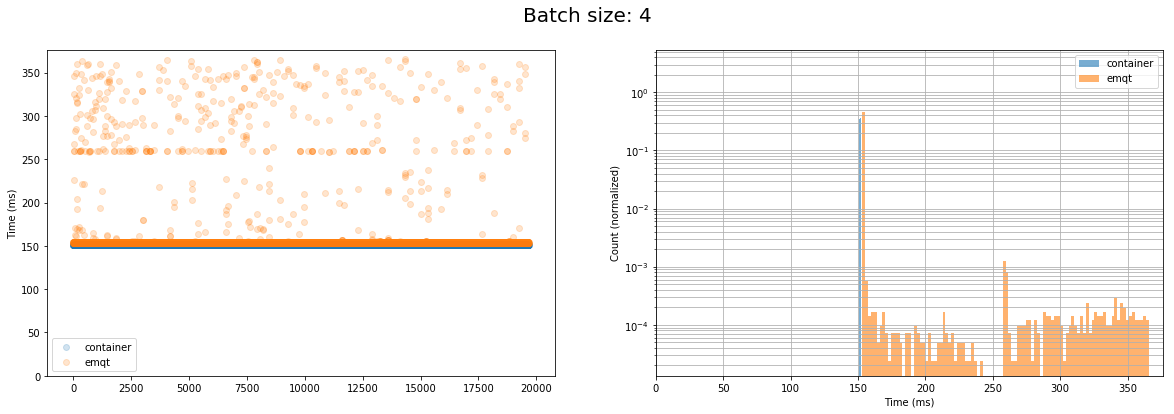

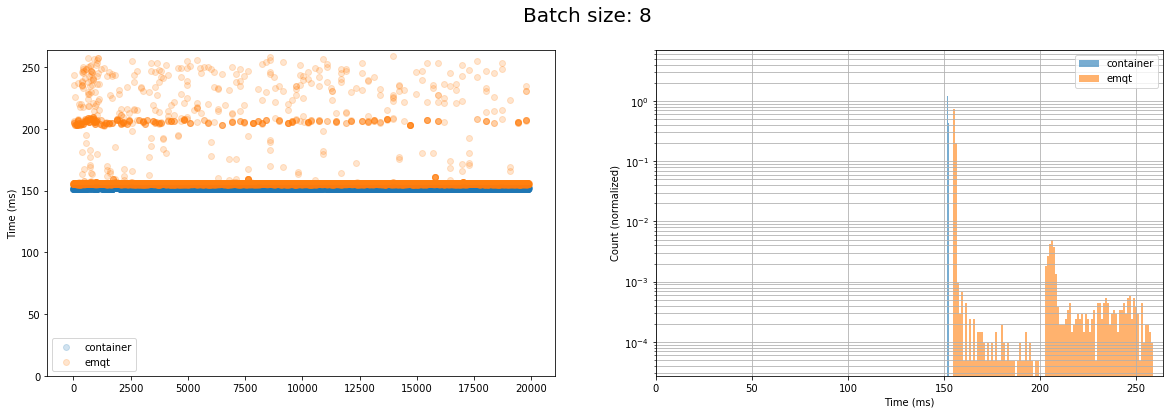

In [43]:
path = os.path.abspath("../results_cpp_benchmarker/query_lineage/query_lineage_tf_resnet_sleep/")
analyze_dir(path, batch_index=9)

# After Fix

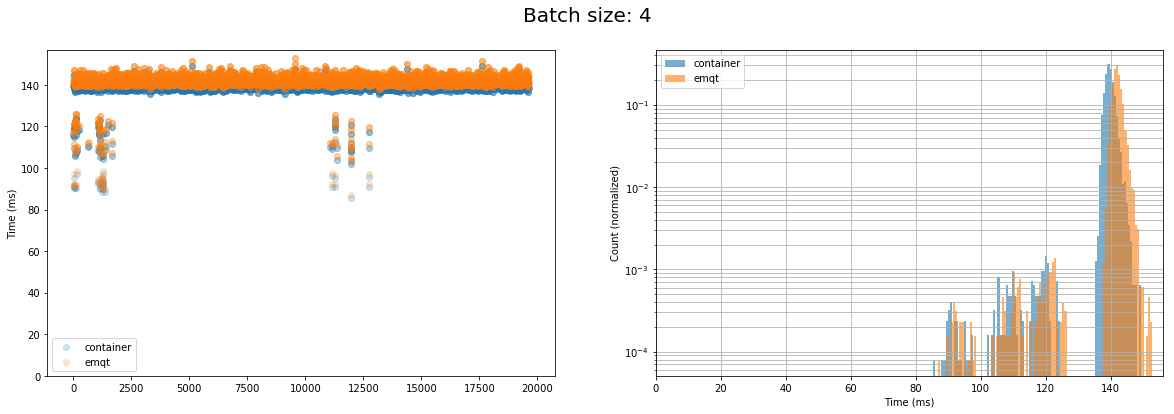

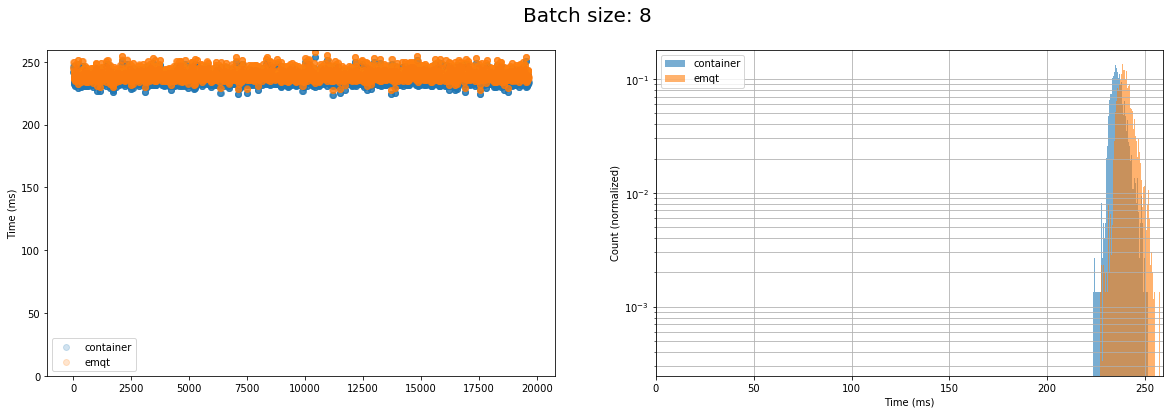

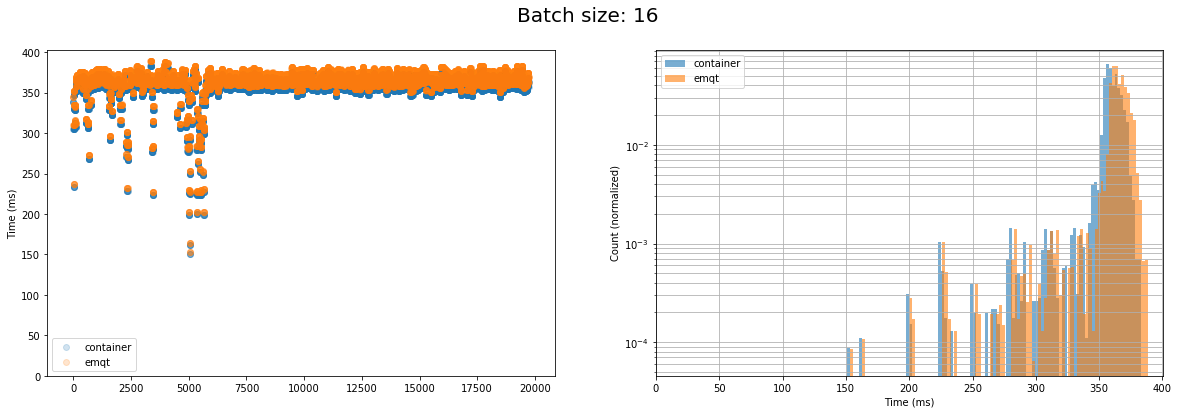

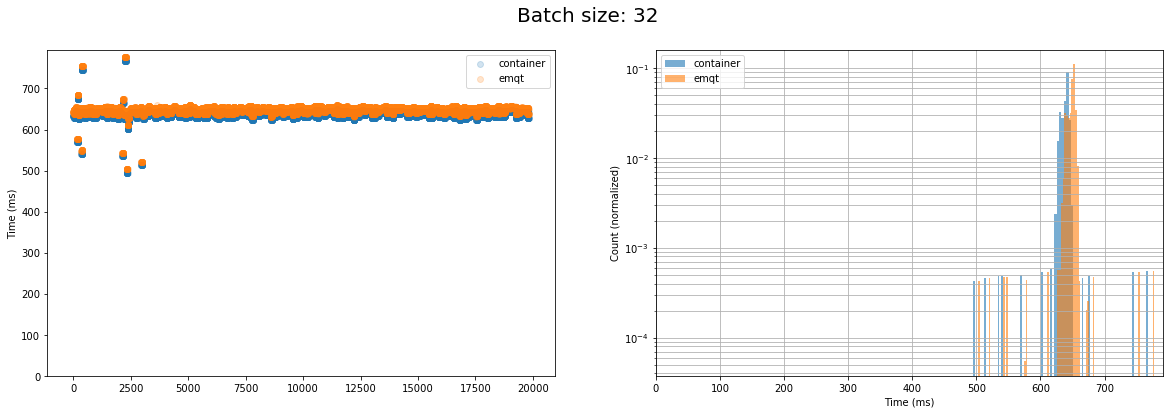

In [42]:
path = os.path.abspath("../results_cpp_benchmarker/query_lineage/query_lineage_tf_resnet_removed_query_cache/")
analyze_dir(path, batch_index=8)